In [30]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold, StratifiedKFold
from itertools import product
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import torch.nn.init as init

In [31]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)   # fontsize of the tick labels
plt.rc('legend', fontsize=MEDIUM_SIZE)    # legend fontsize
plt.rc('axes', titlesize=MEDIUM_SIZE)    # fontsize of the figure suptitle
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [32]:
def preprocess_monk(file_name):
    '''
    Load data from the Monk dataset and preprocess using one-hot encoding.

    Parameters:
    - file_name (str): The file name of the dataset.

    Returns:
    - x (torch.Tensor): Input data after one-hot encoding.
    - y (torch.Tensor): Target data.
    '''

    # load the dataset, split into input (X) and output (y) variables
    df = pd.read_csv(file_name, delimiter=' ', header=None,
                     names=['_','target', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'data_number'],
                     index_col=False)

    # Extract input features and target variable
    x1, x2, x3, x4, x5, x6, target = (np.array(df[feature]) for feature in ['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'target'])

    # Initialize OneHotEncoder
    encoder = OneHotEncoder(sparse_output=False)

    # Reshape and transform x1 using one-hot encoding
    input_one_hot = encoder.fit_transform(x1.reshape(-1, 1))

    # Loop through the remaining input features and concatenate one-hot encoded values
    for x in [x2,x3,x4,x5,x6]:
        data =x.reshape(-1, 1)
        one_hot_encoded = encoder.fit_transform(data)
        input_one_hot = np.hstack((input_one_hot, one_hot_encoded))

    # Convert to PyTorch tensors
    x = torch.tensor(input_one_hot, dtype=torch.float32)#.cuda()
    y = torch.tensor(target, dtype=torch.float32).reshape(-1,1)#.cuda()

    return x, y

# Load the dataset

In [36]:
x_train, y_train = preprocess_monk(file_name='monk_data/monks-1.train')
x_test, y_test = preprocess_monk(file_name='monk_data/monks-1.test')

print(x_train.shape)
print(y_train.shape)

print(x_test.shape)
print(y_test.shape)

torch.Size([124, 17])
torch.Size([124, 1])
torch.Size([432, 17])
torch.Size([432, 1])
tensor([[1., 0., 0.,  ..., 0., 1., 0.],
        [1., 0., 0.,  ..., 0., 0., 1.],
        [1., 0., 0.,  ..., 0., 1., 0.],
        ...,
        [0., 0., 1.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 1., 0., 1.]])


In [ ]:
from sklearn import svm

model = svm.SVC(kernel='linear')

# Coarse Grid Searches (to find best kernel)
we perform two grid searches. One with the rbf kernel, and one with polinomial kernel.
In the grid search with rbf, we include the hyperparameter 'gamma', related to the std of the gaussian kernel.
In the case of the polinomial kernel we include the degree of the polinomial as hyperparameter.
We compare the results of k-fold cross validation to choose the kernel most suitable for our problem.

In [34]:

#first coarse grid search
kernels = ['rbf']
Cs = [0.01,0.1,1,10,100,1000]
epsilons = [0.01,0.1,1,10]
degrees=[0] #only relevant for poly kernel
gammas = ['scale',0.01,0.1,1,10] #related to sigma in rbf
#Best Hp: ['rbf', 1000, 0.1] with MEE = 0.6396615599226871 +- 0.04980493197143183
# Best Hp: ['rbf', 1000, 0.1, 0, 'scale'] with MEE = 0.6396615599226871 +- 0.04980493197143183


'''
kernels = ['poly']
Cs = [0.01,0.1,1,10,100,1000]
degrees = np.arange(3,30,1)
epsilons = [0.01,0.1,1,10]
gammas = ['scale'] # related to sigma in rbf
#Best Hp: ['poly', 1000, 0.01, 5] with MEE = 0.8183841594881777 +- 0.12792331527745304
'''

best_hyperparams = perform_grid_search_kfold(kernels,
                          Cs,
                          epsilons,
                          degrees,
                          gammas,
                          k_folds=3,
                          x=X_train,
                          y=y_train)

NameError: name 'X_train' is not defined

# Finer Grid Search
the best kernel is rbf, now let's study the other hyperparameters more in detail

In [ ]:

#finer grid search
kernels = ['rbf']
Cs = [1000,2000,3000,4000,5000]
epsilons = [0.1,0.2,0.3,0.4,0.5]
gammas = ['scale',0.1,0.2,0.3,0.4,0.5] #related to sigma in rbf
# Best Hp: ['rbf', 3000, 0.1] with MEE = 0.6172759223965806 +- 0.06576969897515686


'''
#best hp untill now:
kernels = ['rbf']
Cs = [3000]
epsilons = [0.1]
'''

best_hyperparams = perform_grid_search_kfold(kernels,
                          Cs,
                          epsilons,
                          degrees,
                          gammas,
                          k_folds=3,
                          x=X_train,
                          y=y_train)

total number of grid search combinations explored: 150
1/150 Hyperparams: rbf 1000 0.1 0 scale
Final Results: kernel=rbf; C=1000; epsilon=0.1; deg = 0; gamma = scale --> train_mee = 0.2563 +- 0.003463
Final Results: kernel=rbf; C=1000; epsilon=0.1; deg = 0, gamma = scale --> val_mee = 0.6397 +- 0.0498
2/150 Hyperparams: rbf 1000 0.1 0 0.1
Final Results: kernel=rbf; C=1000; epsilon=0.1; deg = 0; gamma = 0.1 --> train_mee = 0.3602 +- 0.01066
Final Results: kernel=rbf; C=1000; epsilon=0.1; deg = 0, gamma = 0.1 --> val_mee = 0.6922 +- 0.04473
3/150 Hyperparams: rbf 1000 0.1 0 0.2
Final Results: kernel=rbf; C=1000; epsilon=0.1; deg = 0; gamma = 0.2 --> train_mee = 0.212 +- 0.003211
Final Results: kernel=rbf; C=1000; epsilon=0.1; deg = 0, gamma = 0.2 --> val_mee = 0.6235 +- 0.05651
4/150 Hyperparams: rbf 1000 0.1 0 0.3
Final Results: kernel=rbf; C=1000; epsilon=0.1; deg = 0; gamma = 0.3 --> train_mee = 0.1688 +- 0.002388
Final Results: kernel=rbf; C=1000; epsilon=0.1; deg = 0, gamma = 0.3 --

### Study the effect of the parameter C.
Keeping $\varepsilon$ fixed, we want to study the effect of C on the validation error. 
- Low C ---> many TR errors are allowed (risk of underfitting)
- High C ---> less TR errors allowed (risk of overfitting)

In [ ]:
kernels = ['rbf']
Cs = np.arange(200, 10000, 200)
epsilons = [0.1]
#Best Hp: ['rbf', 2800, 0.1] with MEE = 0.6164267250857903 +- 0.0641407687516038

best_hyperparams, mees, mees_sd = perform_grid_search_kfold(kernels,
                          Cs,
                          epsilons,
                          degrees=[0],
                          gammas=['scale'],
                          k_folds=3,
                          x=X_train,
                          y=y_train,
                          return_sequence=True)

total number of grid search combinations explored: 49
1/49 Hyperparams: rbf 200 0.1 0 scale
Final Results: kernel=rbf; C=200; epsilon=0.1; deg = 0; gamma = scale --> train_mee = 0.4276 +- 0.01233
Final Results: kernel=rbf; C=200; epsilon=0.1; deg = 0, gamma = scale --> val_mee = 0.7814 +- 0.04356
2/49 Hyperparams: rbf 400 0.1 0 scale
Final Results: kernel=rbf; C=400; epsilon=0.1; deg = 0; gamma = scale --> train_mee = 0.3353 +- 0.007962
Final Results: kernel=rbf; C=400; epsilon=0.1; deg = 0, gamma = scale --> val_mee = 0.6983 +- 0.04279
3/49 Hyperparams: rbf 600 0.1 0 scale
Final Results: kernel=rbf; C=600; epsilon=0.1; deg = 0; gamma = scale --> train_mee = 0.2955 +- 0.006089
Final Results: kernel=rbf; C=600; epsilon=0.1; deg = 0, gamma = scale --> val_mee = 0.6667 +- 0.0422
4/49 Hyperparams: rbf 800 0.1 0 scale
Final Results: kernel=rbf; C=800; epsilon=0.1; deg = 0; gamma = scale --> train_mee = 0.2717 +- 0.004084
Final Results: kernel=rbf; C=800; epsilon=0.1; deg = 0, gamma = scale 

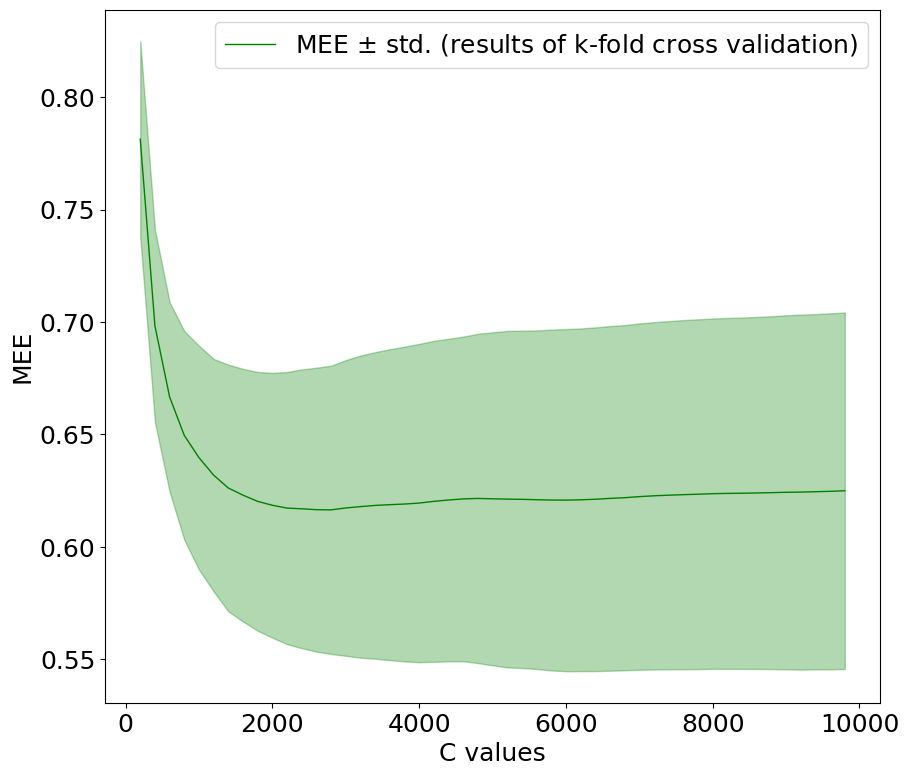

In [ ]:
#plot the values of mees changing the values of C
plot_mean_std(Cs,mees,mees_sd, label = 'C', color='green')

### Study the effect of the parameter $\varepsilon$.
Keeping C fixed, we want to study the effect of $\varepsilon$ on the validation error. 

In [ ]:
kernels = ['rbf']
Cs = [2800]
epsilons = np.arange(0.01,0.2,0.01)
#Best Hp: ['rbf', 2800, 0.1] with MEE = 0.6164267250857903 +- 0.0641407687516038

best_hyperparams, mees, mees_sd = perform_grid_search_kfold(kernels,
                          Cs,
                          epsilons,
                          degrees=[0],
                          gammas=['scale'],
                          k_folds=3,
                          x=X_train,
                          y=y_train,
                          return_sequence=True)

total number of grid search combinations explored: 19
1/19 Hyperparams: rbf 2800 0.01 0 scale
Final Results: kernel=rbf; C=2800; epsilon=0.01; deg = 0; gamma = scale --> train_mee = 0.1522 +- 0.00291
Final Results: kernel=rbf; C=2800; epsilon=0.01; deg = 0, gamma = scale --> val_mee = 0.6233 +- 0.06095
2/19 Hyperparams: rbf 2800 0.02 0 scale
Final Results: kernel=rbf; C=2800; epsilon=0.02; deg = 0; gamma = scale --> train_mee = 0.1557 +- 0.003075
Final Results: kernel=rbf; C=2800; epsilon=0.02; deg = 0, gamma = scale --> val_mee = 0.6192 +- 0.06115
3/19 Hyperparams: rbf 2800 0.03 0 scale
Final Results: kernel=rbf; C=2800; epsilon=0.03; deg = 0; gamma = scale --> train_mee = 0.1599 +- 0.003141
Final Results: kernel=rbf; C=2800; epsilon=0.03; deg = 0, gamma = scale --> val_mee = 0.6157 +- 0.06102
4/19 Hyperparams: rbf 2800 0.04 0 scale
Final Results: kernel=rbf; C=2800; epsilon=0.04; deg = 0; gamma = scale --> train_mee = 0.1646 +- 0.003463
Final Results: kernel=rbf; C=2800; epsilon=0.04

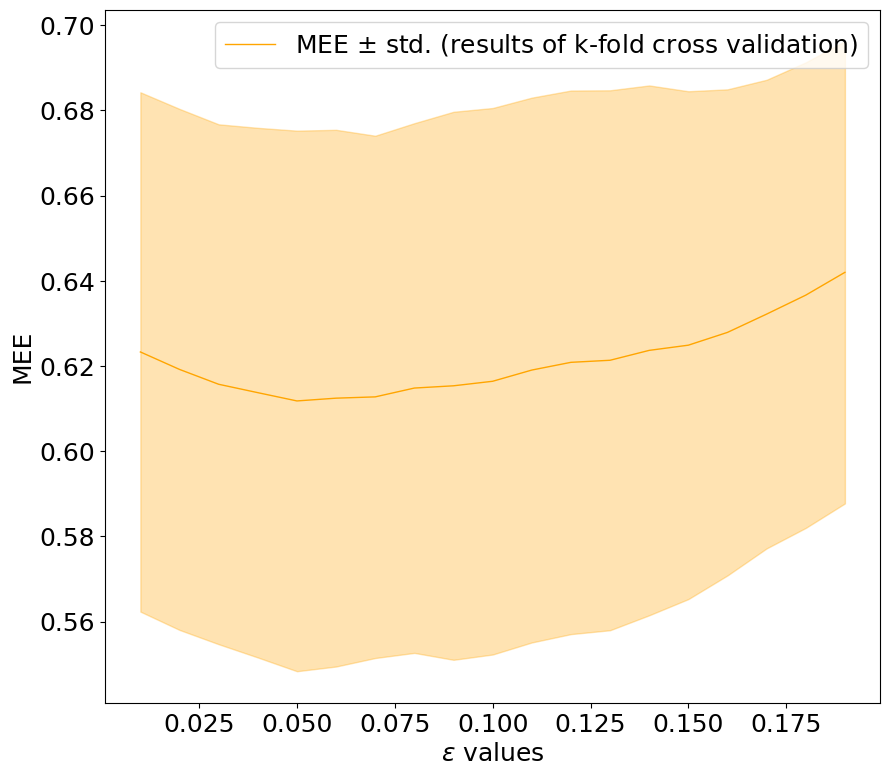

In [ ]:
#plot the values of mees changing the values of C
plot_mean_std(epsilons,mees,mees_sd, label='$\epsilon$', color='orange')

In [ ]:
#final model from model selection:
kernels = ['rbf']
Cs = [2800]
epsilons = [0.05]

best_hyperparams, mees, mees_sd = perform_grid_search_kfold(kernels,
                          Cs,
                          epsilons,
                          degrees=[0],
                          gammas=['scale'],
                          k_folds=3,
                          x=X_train,
                          y=y_train,
                          return_sequence=True)

total number of grid search combinations explored: 1
1/1 Hyperparams: rbf 2800 0.05 0 scale
Final Results: kernel=rbf; C=2800; epsilon=0.05; deg = 0; gamma = scale --> train_mee = 0.1696 +- 0.003877
Final Results: kernel=rbf; C=2800; epsilon=0.05; deg = 0, gamma = scale --> val_mee = 0.6118 +- 0.06344
Best Hp: ['rbf', 2800, 0.05, 0, 'scale'] with MEE = 0.6118105186695858 +- 0.06344420890556922


# Train the final model on all the training data
Finally, we train our best model on all the training data.
We test its performances on our internal test set.

In [ ]:
best_hyperparams = ['rbf', 2800, 0.05]
model = MultiSVM(*best_hyperparams)
model.fit(X_train,y_train)
print('Test MEE:',mean_euclidean_error(model.predict(X_test),y_test))

Test MEE: 0.5096504558449603


In [ ]:
# Check the number of support vectors
sv0 = model.svr0.support_vectors_.shape[0]
sv1 = model.svr1.support_vectors_.shape[0]
sv2 = model.svr2.support_vectors_.shape[0]

print("Number of support vectors:", sv0,sv1,sv2)

Number of support vectors: 639 651 603


# Compute R^2

In [ ]:
predictions = model.predict(X_test)
o0 = predictions[:,0]
o1 = predictions[:,1]
o2 = predictions[:,2]
y0_test = y_test[:,0]
y1_test = y_test[:,1]
y2_test = y_test[:,2]

0.999582935798902


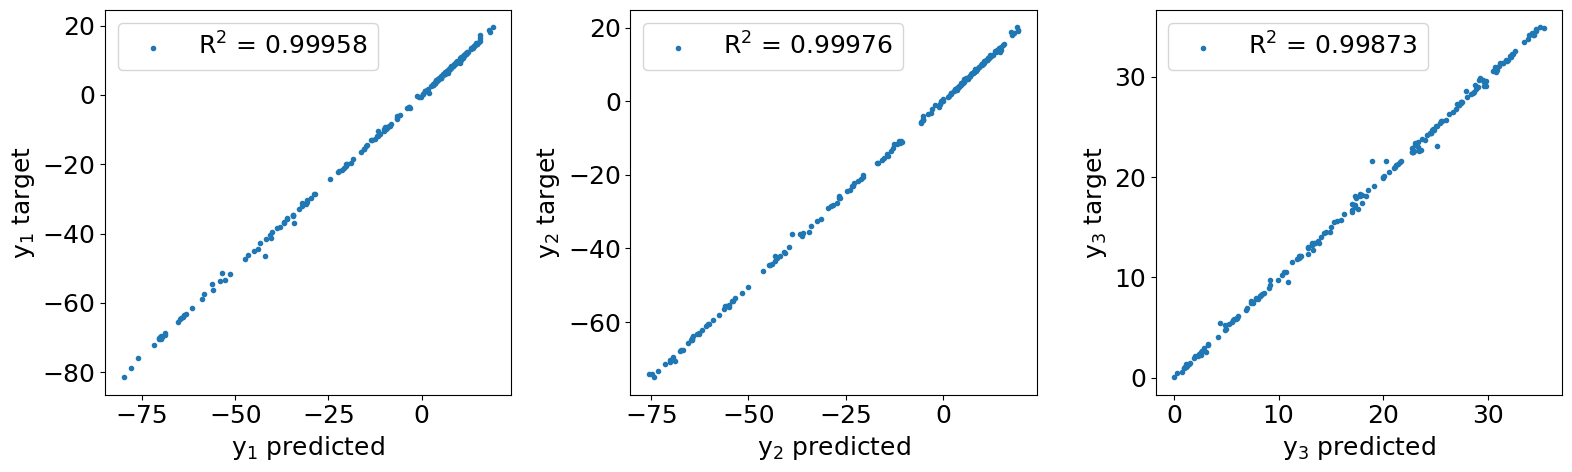

In [ ]:
from sklearn.metrics import r2_score
r_squared = r2_score(o0, y0_test)
print(r_squared)
plt.figure(figsize=(16,5))
plt.subplot(1,3,1)
plt.scatter(o0,y0_test, label=f'R$^2$ = {r2_score(o0, y0_test):.5}', marker='.')
plt.xlabel('y$_1$ predicted')
plt.ylabel('y$_1$ target')
plt.legend()
plt.subplot(1,3,2)
plt.scatter(o1,y1_test, label=f'R$^2$ = {r2_score(o1, y1_test):.5}', marker='.')
plt.xlabel('y$_2$ predicted')
plt.ylabel('y$_2$ target')
plt.legend()
plt.subplot(1,3,3)
plt.scatter(o2,y2_test, label=f'R$^2$ = {r2_score(o2, y2_test):.5}', marker='.')
plt.xlabel('y$_3$ predicted')
plt.ylabel('y$_3$ target')
plt.legend()
plt.tight_layout()
plt.show()

# Final Retraining
As a final step we retrain our model again wit **all the data**, including the internal test set.
We do this **after** model assessment, in this way we do not violate the gold rule!

In [ ]:
dataset = np.loadtxt('ML-CUP23-TR.csv', delimiter=',')
X = dataset[:,1:11]
y = dataset[:,11:14]
best_hyperparams = ['rbf', 2800, 0.05]
model = MultiSVM(*best_hyperparams)
model.fit(X,y)

# Load blind Test dataset

In [ ]:
dataset = np.loadtxt('ML-CUP23-TS.csv', delimiter=',')
X_blind = dataset[:,1:11]
y_blind = model.predict(X_blind)
id = np.arange(1,len(y_blind)+1, dtype=int)

## Save outputs in the required format

In [ ]:
import pandas as pd
import csv

file_path = 'Cantucci_e_Soppressata_ML-CUP-23-TS.csv'

df = pd.DataFrame(y_blind, index=id, columns=['Column1', 'Column2', 'Column3'])
df.to_csv(file_path, header=False)

# Data to be added at the beginning
new_lines = [
    ['# Noemi Boni',' Lorenzo Zaffina'],
    ['# Cantucci_e_Soppressata'],
    ['# ML-CUP23'],
    ['# 14/02/2024']
]

# Read the existing content of the CSV file
with open(file_path, 'r', newline='') as csvfile:
    existing_content = list(csv.reader(csvfile))

# Insert the new lines at the beginning
existing_content[:0] = new_lines

# Write the updated content back to the CSV file
with open(file_path, 'w', newline='') as csvfile:
    csv_writer = csv.writer(csvfile)
    csv_writer.writerows(existing_content)

print(f'Data has been appended to the beginning of {file_path}')

Data has been appended to the beginning of Cantucci_e_Soppressata_ML-CUP-23-TS.csv
